In [1]:
from collections import Counter
from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras import backend as K
from keras import objectives
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
# Load sequences.
sequences = []
years = []
for s in SeqIO.parse('h3n2.fasta', 'fasta'):
    try:
        # assert len(s) == 566
        year = int(s.id.split('/')[-1])
        assert year in range(2000, 2018)
        
        sequences.append(s)
        years.append(year)
    except:
        pass

# Find distribution of lengths
lengths = [len(s) for s in sequences]
len_counts = Counter(lengths)
max(len_counts.keys())

570

In [3]:
len_counts

Counter({565: 1, 566: 8349, 570: 1})

In [4]:
len(sequences), len(years)

(8351, 8351)

In [5]:
# Pad sequences until they are of length max sequence length.
for s in sequences:
    while len(s) < max(len_counts.keys()):
        s.seq += '*'     

In [6]:
# Figure out how many unique letters are being used.
letters = set()
for s in sequences:
    letters = letters.union(s.seq)
print(letters)

{'V', 'H', 'C', 'E', 'X', 'A', 'J', 'R', 'F', 'P', 'M', 'B', 'W', 'K', 'D', 'Y', 'S', 'L', 'I', '*', 'G', 'N', 'Q', 'Z', 'T'}


In [7]:
# Convert sequences into numpy array.
char_array = np.chararray(shape=(len(sequences), max(len_counts.keys())), unicode=True)
# arr = np.array([list(rec) for rec in sequences])
char_array
for i, seq in enumerate(sequences):
    char_array[i, :] = list(seq)

In [8]:
char_array.shape

(8351, 570)

In [9]:
lb = LabelBinarizer()
lb.fit(list(letters))

input_array = np.zeros(shape=(char_array.shape[0], max(len_counts.keys()) * len(letters)))
print(input_array.shape)
for i in range(char_array.shape[1]):
    input_array[:, i*len(letters):(i+1)*len(letters)] = lb.transform(char_array[:, i])

(8351, 14250)


In [10]:
np.unique(input_array)

array([ 0.,  1.])

In [11]:
input_array[0, 0:len(letters)]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [12]:
intermediate_dim = 1000
encoding_dim = 2
latent_dim = encoding_dim
epsilon_std = 1.0
nb_epoch = 250

x = Input(shape=(input_array.shape[1],))
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim, ), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


def vae_loss(x, x_decoded_mean):
    xent_loss = input_array.shape[1] * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_decoded_mean = Dense(input_array.shape[1], activation='sigmoid')(z_mean)

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='adam', loss=vae_loss)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
encoder_var = Model(x, z_log_var)

x_train, x_test = train_test_split(input_array)

early_stopping = EarlyStopping(monitor="val_loss", patience=5)

In [13]:
# build the decoder
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = vae.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [14]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        validation_data=(x_test, x_test),
        callbacks=[early_stopping],
       )

Train on 6263 samples, validate on 2088 samples
Epoch 1/250
6263/6263 [==============================] - 2s - loss: 2291.2696 - val_loss: 751.9887

In [15]:
embeddings_mean = encoder.predict(input_array)
embeddings_var = encoder_var.predict(input_array)

In [16]:
embeddings_mean.shape

(8351, 2)

In [17]:
years.index(2017)

1813

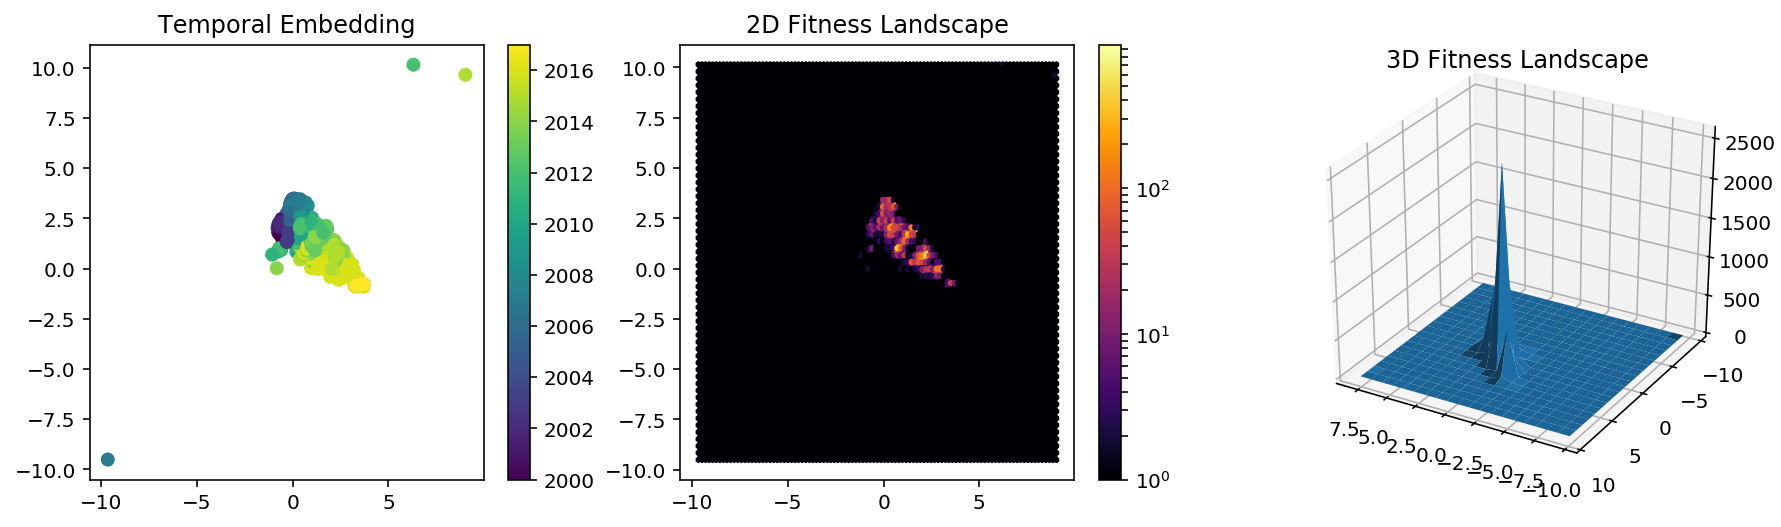

In [18]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 3, 1)
plt.scatter(embeddings_mean[:, 0], embeddings_mean[:, 1], c=years)
plt.colorbar(ax=ax1)
ax1.set_title('Temporal Embedding')

ax2 = fig.add_subplot(1, 3, 2)
plt.hexbin(embeddings_mean[:, 0], embeddings_mean[:, 1], norm=colors.LogNorm(), cmap='inferno')
plt.colorbar(ax=ax2)
ax2.set_title('2D Fitness Landscape')

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
xs = embeddings_mean[:, 0]
ys = embeddings_mean[:, 1]
histo, xbins, ybins = np.histogram2d(xs, ys, bins=20)
xx, yy = np.meshgrid(xbins, ybins)
xx = xx[0:-1, :-1]
yy = yy[0:-1, :-1]
ax3.view_init(elev=30, azim=120)
ax3.plot_surface(xx, yy, histo)
ax3.set_title('3D Fitness Landscape')
plt.savefig('embedding-h3n2.pdf', bbox_inches='tight')

The caveats to the fitness landscapes is clear: by plotting the histogram on the Z-axis, we are assuming that the number of sampled sequences equals to the prevalence (i.e. true fitness measure). Where prevalence not proportional to sampled number of sequences, this interpretation is invalid.

In [19]:
str(sequences[0].seq)

'MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTITNDQIEVTNATELVQSSSTGEICNSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAHSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSNNSFFSRLNWLTHLNFKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQAAGRITVSTKRSQQAVIPNIGSRPRVRNIPSRVSIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCNSACITPNGSIPNDKPFQNVNRITYGACPRYVKQNTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNGTYDHDVYRDEALNNRFQIKGVELKSGYKDWILWISFAISCFLLCVALLGFIMWACQKGNIRCNICI****'

In [20]:
# Get coordinates of a valid sequence
input_array[0, 0:len(letters)]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [21]:
# Forward generate new sequences.
new_coords = np.array([[20, 20],
                       [20, 20]]).reshape(-1,2)

# new_seqs = np.rint(decoder.predict(new_coords))
new_seqs = decoder.predict(new_coords)

def numarr_to_letterarr(arr):
    strings = np.chararray(shape=((arr.shape[0], int(arr.shape[1] / len(letters)))), unicode=True)
    for s in range(arr.shape[0]):
        seqlength = int(arr.shape[1] / len(letters))
        for i in range(seqlength):
            pos_arr = arr[:, i * len(letters): (i+1) * len(letters)]
            strings[:, i] = lb.inverse_transform(pos_arr)
    return strings

new_strarr = numarr_to_letterarr(new_seqs)
new_strarr

chararray([['M', 'K', 'T', ..., '*', '*', '*'],
       ['M', 'K', 'T', ..., '*', '*', '*']], 
      dtype='<U1')

In [22]:
def arr_to_str(letter_array):
    return ''.join([i for i in letter_array])

arr_to_str(new_strarr[0])

'MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSNSSFFSRLNWLTHLNFKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRNIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNGTYDHNVYRDEALNNRFQIKGVELKSGYKDWILWISFAISCFLLCVALLGFIMWACQKGNIRCNICI****'

In [23]:
pos = 2
pos_enc = new_seqs[:, pos * len(letters):(pos+1) * len(letters)]
str(lb.inverse_transform(pos_enc)[0])

'T'

In [24]:
new_seqs.shape[1] / len(letters)

570.0

In [25]:
sequences[1813]

SeqRecord(seq=Seq('MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITSDRIEVTN...***', SingleLetterAlphabet()), id='A/Colorado/01/2017', name='A/Colorado/01/2017', description='A/Colorado/01/2017', dbxrefs=[])

In [26]:
reconstruct = numarr_to_letterarr(decoder.predict(encoder.predict(input_array[1813, :].reshape(1, -1))))[0]
reconstruct

chararray(['M', 'K', 'T', 'I', 'I', 'A', 'L', 'S', 'Y', 'I', 'L', 'C', 'L',
       'V', 'F', 'A', 'Q', 'K', 'I', 'P', 'G', 'N', 'D', 'N', 'S', 'T',
       'A', 'T', 'L', 'C', 'L', 'G', 'H', 'H', 'A', 'V', 'P', 'N', 'G',
       'T', 'I', 'V', 'K', 'T', 'I', 'T', 'N', 'D', 'R', 'I', 'E', 'V',
       'T', 'N', 'A', 'T', 'E', 'L', 'V', 'Q', 'N', 'S', 'S', 'I', 'G',
       'E', 'I', 'C', 'D', 'S', 'P', 'H', 'Q', 'I', 'L', 'D', 'G', 'E',
       'N', 'C', 'T', 'L', 'I', 'D', 'A', 'L', 'L', 'G', 'D', 'P', 'Q',
       'C', 'D', 'G', 'F', 'Q', 'N', 'K', 'K', 'W', 'D', 'L', 'F', 'V',
       'E', 'R', 'S', 'K', 'A', 'Y', 'S', 'N', 'C', 'Y', 'P', 'Y', 'D',
       'V', 'P', 'D', 'Y', 'A', 'S', 'L', 'R', 'S', 'L', 'V', 'A', 'S',
       'S', 'G', 'T', 'L', 'E', 'F', 'N', 'N', 'E', 'S', 'F', 'N', 'W',
       'T', 'G', 'V', 'T', 'Q', 'N', 'G', 'T', 'S', 'S', 'A', 'C', 'I',
       'R', 'R', 'S', 'S', 'S', 'S', 'F', 'F', 'S', 'R', 'L', 'N', 'W',
       'L', 'T', 'H', 'L', 'N', 'Y', 'T', 'Y', 'P', 'A', 'L'

In [27]:
for pos, letter in enumerate(str(sequences[1813].seq)):
    if letter == reconstruct[pos]:
        pass
    else:
        print(pos, letter)

46 S


In [28]:
# Let's sample some new sequences from around a 2017 one.
variances = encoder_var.predict(input_array[1813, :].reshape(1, -1))
means = encoder.predict(input_array[1813, :].reshape(1, -1))
def np_sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal(loc=0.,
                               scale=epsilon_std)
    return z_mean + np.exp(z_log_var / 2) * epsilon

new_starting_points = np_sampling([means, variances])
new_starting_points, means

(array([[ 2.89759135,  0.03460712]], dtype=float32),
 array([[ 2.92516446,  0.06760571]], dtype=float32))

In [29]:
from Levenshtein import distance

# Compute Levenshtein distance between two really distant sequences
seq_coords = np.array([new_starting_points[0], means[0]])
seq_arrays = decoder.predict(seq_coords)
letter_arrays = numarr_to_letterarr(seq_arrays)

sequences = []
for row in range(letter_arrays.shape[0]):
    string = ''.join(letter for letter in letter_arrays[row])
    sequences.append(string)

distance(sequences[0], sequences[1])

0

(-5, 5)

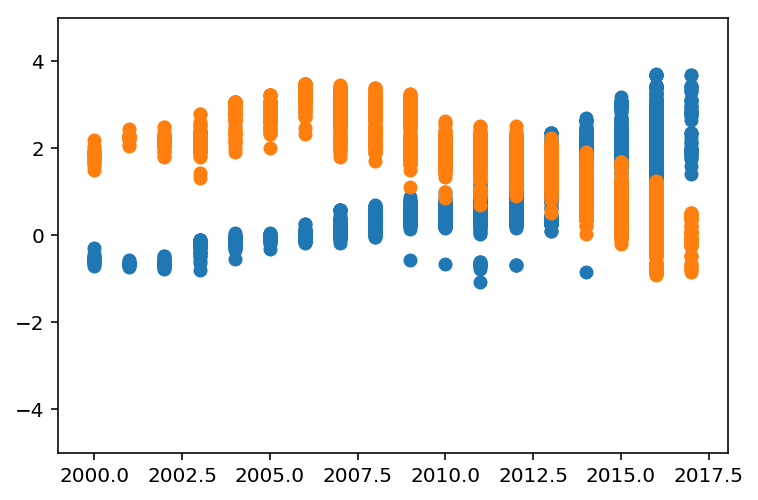

In [34]:
# Let's try doing some temporal scatterplots.

plt.scatter(years, embeddings_mean[:, 0])
plt.scatter(years, embeddings_mean[:, 1])
plt.ylim(-5, 5)